<a href="https://colab.research.google.com/github/Dhvanishere/jubilant-adventure/blob/main/NLP_Group_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import chardet


In [ ]:
# # Convert all entries to strings to handle non-string values
# data[text_column] = data[text_column].astype(str)

# # Apply preprocessing to each text entry
# data['cleaned_text'] = data[text_column].map(preprocess_text)

# # Alternative: Using list comprehensions
# texts = [preprocess_text(text) for text in data[text_column]]
# labels = data[label_column].tolist()

# another approach
# Convert all entries to strings to handle non-string values
# data[text_column] = data[text_column].astype(str)

# # Apply preprocessing to each text entry
# data['cleaned_text'] = data[text_column].map(preprocess_text)

# # Alternative: Using list comprehensions
# texts = [preprocess_text(text) for text in data[text_column]]
# labels = data[label_column].tolist()

# new code: Glove SVM Model

In [ ]:
# from google.colab import drive
# file = drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install numpy pandas scikit-learn emoji chardet matplotlib seaborn

#Data Preprocessing and Feature engineering

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, accuracy_score, log_loss
import emoji
from nltk.tokenize import word_tokenize

# Load data from Excel file
df=pd.read_csv('/Sentiment_Data.csv', encoding='ISO-8859-1')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451332 entries, 0 to 451331
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Tweet      451331 non-null  object
 1   Sentiment  451332 non-null  object
dtypes: object(2)
memory usage: 6.9+ MB


In [ ]:
def preprocess_text(text):
    if isinstance(text, str):  # Check if text is a string
        # Handle emojis
        text = emoji.demojize(text)
        # Other preprocessing steps (slang handling, abbreviation handling, negation handling) can be added here
        return text.lower()
    else:
        return ""  # Return an empty string for NaN values

df['Tweet'] = df['Tweet'].apply(preprocess_text)

# Load pre-trained ELMo model
elmo = hub.load("https://tfhub.dev/google/elmo/3")

def text_to_elmo_embeddings(text):
    # Convert text to TensorFlow tensor
    text_tensor = tf.constant([text])
    embeddings = elmo.signatures["default"](text_tensor)["elmo"]
    return embeddings.numpy()[0]

# Convert text data to ELMo embeddings
df['embeddings'] = df['Tweet'].apply(text_to_elmo_embeddings)

# Perform one-hot encoding for sentiment column
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])

# Function to pad or truncate ELMo embeddings
def pad_or_truncate_embeddings(embeddings, max_length):
    padded_embeddings = np.zeros((max_length, embeddings.shape[1]))
    if embeddings.shape[0] <= max_length:
        padded_embeddings[:embeddings.shape[0], :] = embeddings
    else:
        padded_embeddings[:] = embeddings[:max_length, :]
    return padded_embeddings

# Maximum length of ELMo embeddings
max_length = 50

# Pad or truncate ELMo embeddings
df['padded_embeddings'] = df['embeddings'].apply(lambda x: pad_or_truncate_embeddings(x, max_length))

# Convert padded embeddings to NumPy array
X = np.array(df['padded_embeddings'].tolist())
y = np.array(df['sentiment_encoded'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM model with cross-validation
svm_model = SVC(kernel='linear', probability=True)

# Flatten ELMo embeddings
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train SVM model with cross-validation
svm_model = SVC(kernel='linear', probability=True)

# Cross-validation
y_pred_cv = cross_val_predict(svm_model, X_train_flat, y_train, cv=5, method='predict_proba')

# AUC
auc_score = roc_auc_score(y_train, y_pred_cv, multi_class='ovr')

# Confusion matrix
conf_matrix = confusion_matrix(y_train, np.argmax(y_pred_cv, axis=1))

# F1-score
f1 = f1_score(y_train, np.argmax(y_pred_cv, axis=1), average='weighted')

# Accuracy
accuracy = accuracy_score(y_train, np.argmax(y_pred_cv, axis=1))

# Log loss (optional)
logloss = log_loss(y_train, y_pred_cv)

# Print evaluation metrics
print("AUC Score:", auc_score)
print("Confusion Matrix:\n", conf_matrix)
print("F1-Score:", f1)
print("Accuracy:", accuracy)
print("Log Loss:", logloss)



In [ ]:
df.info()

# Data visualization

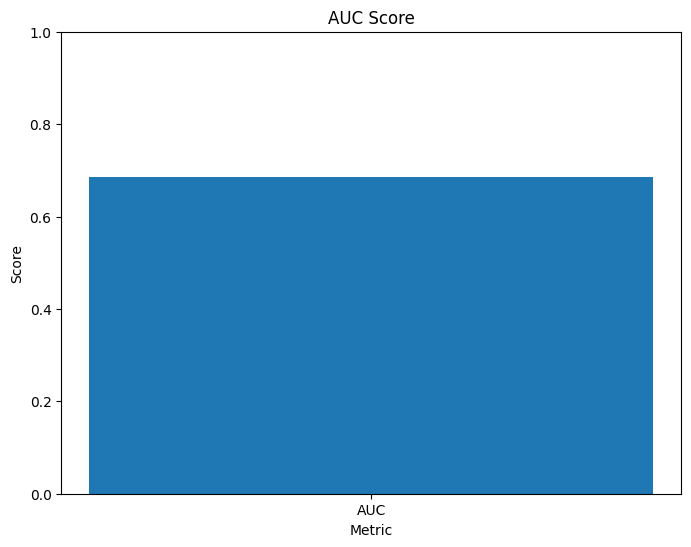

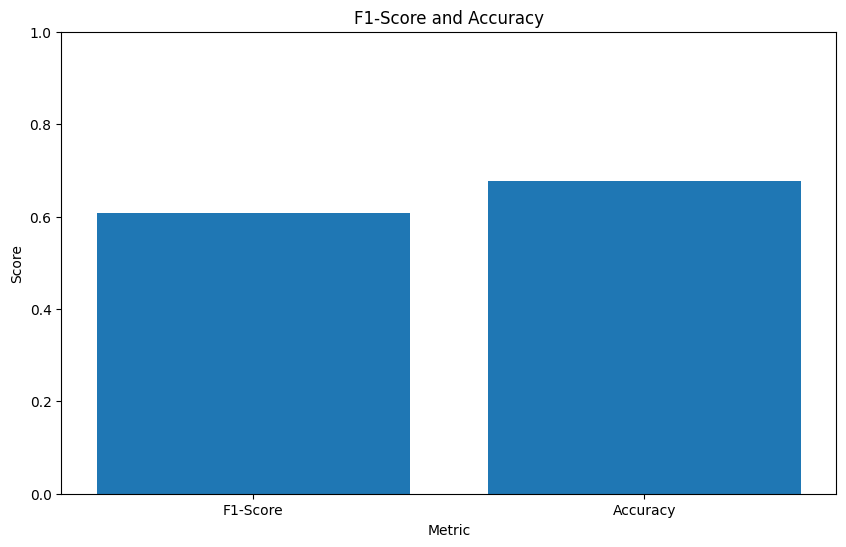

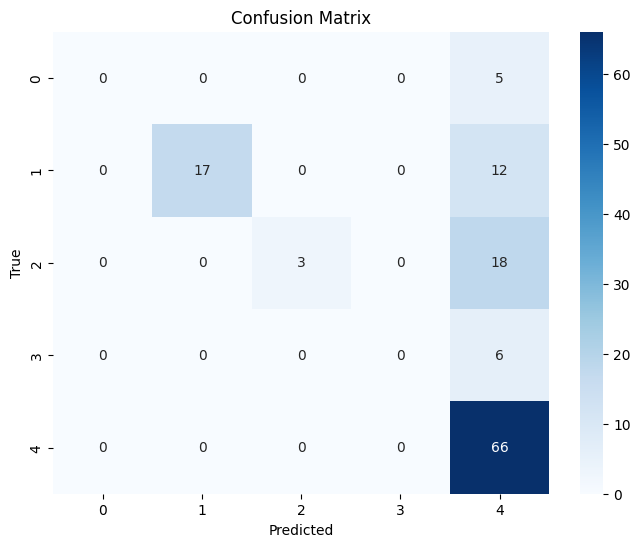

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot AUC score
plt.figure(figsize=(8, 6))
plt.bar(['AUC'], [auc_score])
plt.title('AUC Score')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Plot F1-score and accuracy
plt.figure(figsize=(10, 6))
plt.bar(['F1-Score', 'Accuracy'], [f1, accuracy])
plt.title('F1-Score and Accuracy')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


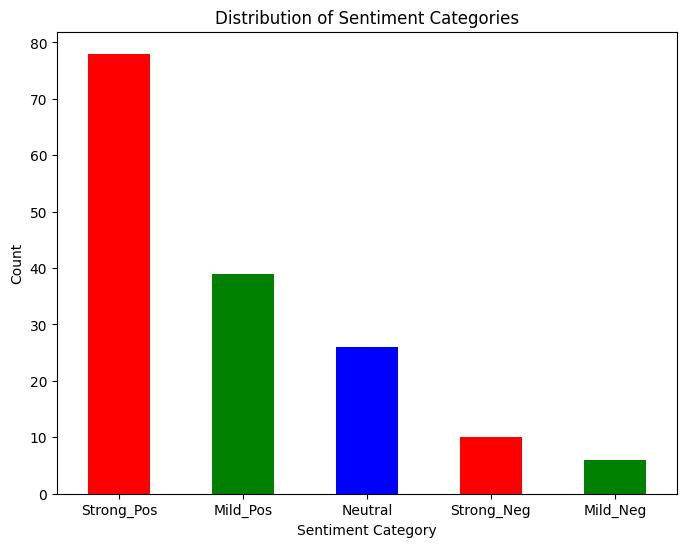

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of sentiment categories
plt.figure(figsize=(8, 6))
df['Sentiment'].value_counts().plot(kind='bar', color=['red', 'green', 'blue'])
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Tweet              159 non-null    object
 1   Sentiment          159 non-null    object
 2   embeddings         159 non-null    object
 3   sentiment_encoded  159 non-null    int64 
 4   padded_embeddings  159 non-null    object
dtypes: int64(1), object(4)
memory usage: 6.3+ KB
